In [4]:
from typing import Dict, TypedDict
import random
from langgraph.graph import StateGraph, START, END

In [6]:
class AgentState(TypedDict):
    name: str
    number: list[int]
    counter: int

In [ ]:
def greeing_node(state: AgentState) -> AgentState:
    """ Greeting node that sets the name in the state. """

    state["name"] = f"Hi there, { state['name']}!"
    state["counter"] = 0   
    
    return state


def random_node(state: AgentState) -> AgentState:
    """ Node that appends a random number to the state's number list. """

    state["number"].append(random.randint(0, 10))
    state["counter"] += 1

    return state


def should_continue(state: AgentState) -> AgentState:
    """ Function to decide what to do next. """
    
    if state["counter"] < 5:
        print(f"Continuing... Current count is {state['counter']}")
        return "loop"
    else:
        return "exit"




In [ ]:
graph = StateGraph(AgentState)

graph.add_node("greeting",greeing_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")

graph.add_conditional_edges(
    "random", # source node
    should_continue, #routing function, ACTION
    {
        "loop": "random", # self-loop back to same node
        "exit": END,     # exit to end node
    }
)

graph.set_entry_point("greeting")

app = graph.compile()

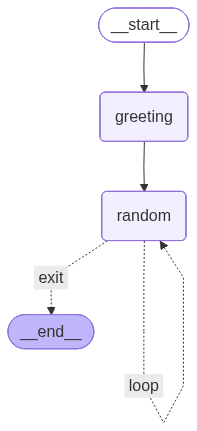

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
app.invoke({"name": "Zakwan",
            "number": [],
            "counter": -1})

Continuing... Current count is 1
Continuing... Current count is 2
Continuing... Current count is 3
Continuing... Current count is 4


{'name': 'Hi there, Zakwan!', 'number': [8, 10, 0, 8, 1], 'counter': 5}

## Guess Numbers In LangChain

In [18]:
class GameState(TypedDict):
    player_name: str
    target_number: int
    guesses: list[int]
    attempts: int
    hints: str
    lower_bound: int
    upper_bound: int

In [19]:
def setup_node(state: GameState) -> GameState:
    """ Setup node that initializes random target Number """

    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hints"] = "Game Started! Try to Guess the Number."
    state["lower_bound"] = 1
    state["upper_bound"] = 20
    print(f"Welcome {state['player_name']}! I have selected a number between 1 and 20. Can you guess it?")

    return state

In [20]:
def guess_node(state: GameState) -> GameState:
    """ Generate a Smarter Guess bsaed on previous hints """
    possible_guesses = list(range(state["lower_bound"], state["upper_bound"]))
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        guess = random.randint(state["lower_bound"], state["upper_bound"])
    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt  {state['attempts']}: My guess is {guess} ( current range: {state['lower_bound']} - {state['upper_bound']})")

    print(state["hints"])
    return state

In [24]:
def hint_node( state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""

    latest_guess = state['guesses'][-1]
    target = state['target_number']

    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"
        
        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")
        
    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"
      
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")

    return state

In [21]:
def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""

# 2 end conditions, 1) 7 is reached or 2)correct number is guessed

    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"



In [ ]:
graph = StateGraph(GameState)

graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)

graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")

graph.add_conditional_edges(
    "hint_node", should_continue,
    {
        #Edge : Nodef
        "continue": "guess",
        "end": END
    }
)

graph.set_entry_point("setup")
app = graph.compile()

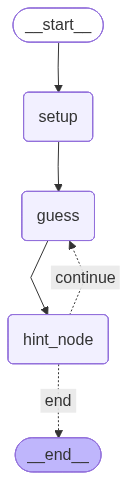

In [26]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
result = app.invoke({"player_name": "Student", "guesses": [], "attempts": 0, "lower_bound": 1, "upper_bound": 20})


Welcome Student! I have selected a number between 1 and 20. Can you guess it?
Attempt  1: My guess is 14 ( current range: 1 - 20)
Game Started! Try to Guess the Number.
Hint: The number 14 is too high. Try lower!
CONTINUING: 1/7 attempts used
Attempt  2: My guess is 7 ( current range: 1 - 13)
Game Started! Try to Guess the Number.
Hint: The number 7 is too high. Try lower!
CONTINUING: 2/7 attempts used
Attempt  3: My guess is 2 ( current range: 1 - 6)
Game Started! Try to Guess the Number.
Hint: The number 2 is too low. Try higher!
CONTINUING: 3/7 attempts used
Attempt  4: My guess is 5 ( current range: 3 - 6)
Game Started! Try to Guess the Number.
Hint: The number 5 is too high. Try lower!
CONTINUING: 4/7 attempts used
Attempt  5: My guess is 3 ( current range: 3 - 4)
Game Started! Try to Guess the Number.
Hint: The number 3 is too low. Try higher!
CONTINUING: 5/7 attempts used
Attempt  6: My guess is 4 ( current range: 4 - 4)
Game Started! Try to Guess the Number.
Success! Correct! Y